In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset

import pandas as pd
import numpy as np
from tqdm import tqdm
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
from sklearn.metrics import r2_score
from datetime import datetime

/tmp/ipykernel_39684/1333878994.py:6: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


In [2]:
class BearLakeDataset(Dataset):
    def __init__(self, input_df, period_days, use_wateryear=False):
        super().__init__()
        self.df = input_df.copy()
        self.df['Elevation'] = self.df['Elevation'].interpolate(method='linear')
        self.scaler = StandardScaler()
        self.df.iloc[:, 2:] = self.scaler.fit_transform(self.df.iloc[:, 2:].values)
        self.period = period_days
        # Calculate the water year min/max if the period is longer than 365 days
        self.use_wateryear = use_wateryear
        if use_wateryear and period_days >= 365:
            self.tmp_df = self.df[['date', 'Elevation']].copy()
            self.tmp_df['month'] = self.tmp_df['date'].dt.month
            self.tmp_df['date']  = self.tmp_df['date'].dt.year
            # Convert year to water year
            def water_year(row):
                if row['month'] >= 10:  # October is month 10
                    return pd.Period(year=row['date'] + 1, freq='Y-SEP')
                else:
                    return pd.Period(year=row['date'], freq='Y-SEP')
            self.tmp_df['date'] = self.tmp_df.apply(water_year, axis=1)
            # Find min/max
            self.tmp_df = self.tmp_df.groupby('date')['Elevation'].agg(['min', 'max']).reset_index()

    def __len__(self):
        len = self.df.shape[0] - self.period
        return len + 1
    
    def __getitem__(self, index):
        X = self.df.iloc[index:index+self.period, 2:].values
        if self.use_wateryear and self.period >= 365:
            last_year = self.df.iloc[index + self.period-1].date.year
            Y = self.tmp_df[self.tmp_df.date.dt.year == last_year]
            y_m = Y['min'].values
            y_M = Y['max'].values
            Ys = np.array([y_m, y_M]).flatten()
        else:
            Y = self.df.iloc[index:index+self.period, 1].values
            y_m = Y.min()
            y_M = Y.max()
            Ys = np.array([y_m, y_M])
            
        return torch.tensor(X, dtype=torch.float32), torch.tensor(Ys, dtype=torch.float32)
    


class BearLakeWaterYearLOCA(Dataset):
    def __init__(self, df, period, scaler=None, n_yr_rm=0):
        self.n_yr_rm = n_yr_rm
        self.period = period
        self.df = df
        
        if scaler is None:
            self.scaler = StandardScaler()
            self.df.iloc[:, 1:] = self.scaler.fit_transform(df.iloc[:, 1:].values)
        else:
            self.scaler = scaler
            self.df.iloc[:, 1:] = self.scaler.transform(df.iloc[:, 1:].values)
        
        self.Xs = self.df.iloc[:, 1:]
        self.Ys = self.df.iloc[:, :1]

        self.Ys['month'] = self.Ys['date'].dt.month
        self.Ys['year'] = self.Ys['date'].dt.year

        def water_year(row):
            if row['month'] >= 10:
                return pd.Period(year=row['year']+1, freq='Y-SEP')
            else:
                return pd.Period(year=row['year'], freq='Y-SEP')
        self.Ys['year'] = self.Ys.apply(water_year, axis=1)

        self.wyear_elevations = self.Ys.groupby('year').agg({'date': 'first', 'month': 'first'}).reset_index()
        self.wyear_elevations = self.wyear_elevations.iloc[(self.period - self.n_yr_rm):].reset_index(drop=True)

    def __len__(self):
        return self.wyear_elevations.shape[0]
    
    def __getitem__(self, idx):
        year = self.wyear_elevations.year.iloc[idx].year
        last_day_idx = self.Ys[self.Ys['year'].dt.year == year].date.idxmax()
        X = self.Xs.iloc[last_day_idx-(365*self.period)+1:last_day_idx+1].values
        # Y = self.wyear_elevations.iloc[idx, 1:3].values.astype(np.float32)
        return torch.tensor(X, dtype=torch.float32)#, torch.tensor(Y, dtype=torch.float32)


In [3]:
# Define the GRU model
class GRU_MME(nn.Module):
    def __init__(self, input_size=60, hidden_size=10, output_size=2, num_layers=2, dropout=0.50,
                 scale=20, shift=5914.26, n_en=100, seed=789):
        super(GRU_MME, self).__init__()
        self.scale = scale
        self.shift = shift
        self.n_en = n_en
        self.seed = seed

        self.gru = nn.GRU(input_size, hidden_size, num_layers, batch_first=True, dropout=dropout)
        self.act = nn.Tanh()
        self.do = nn.Dropout(dropout)
        self.fc = nn.Linear(hidden_size, output_size)
        self.serial = nn.Sequential(
            self.do, self.act, self.fc, self.act
        )

    def __hidden_forward(self, x):
        # Initialize hidden state
        h0 = torch.zeros(self.gru.num_layers, x.size(0), self.gru.hidden_size).to(x.device)
        # Forward pass through GRU layer
        out, _ = self.gru(x, h0.detach())
        linear_outputs = self.scale * self.serial(out) + self.shift
        std, mean = torch.std_mean(linear_outputs, dim=1)
        return mean, std
    
    def forward(self, x):
        if self.training:
            mean, std = self.__hidden_forward(x)
        else:
            self.train()
            with torch.no_grad():
                torch.manual_seed(self.seed)
                mean, _ = self.__hidden_forward(x)
                preds = [mean]
                for i in range(1, self.n_en):
                    m, _ = self.__hidden_forward(x)
                    preds.append(m)
                preds = torch.stack(preds)
                mean = preds.mean(0)
                std = preds.std(0)
            self.eval()
        return mean, std

Text(0, 0.5, 'Elevation (ft)')

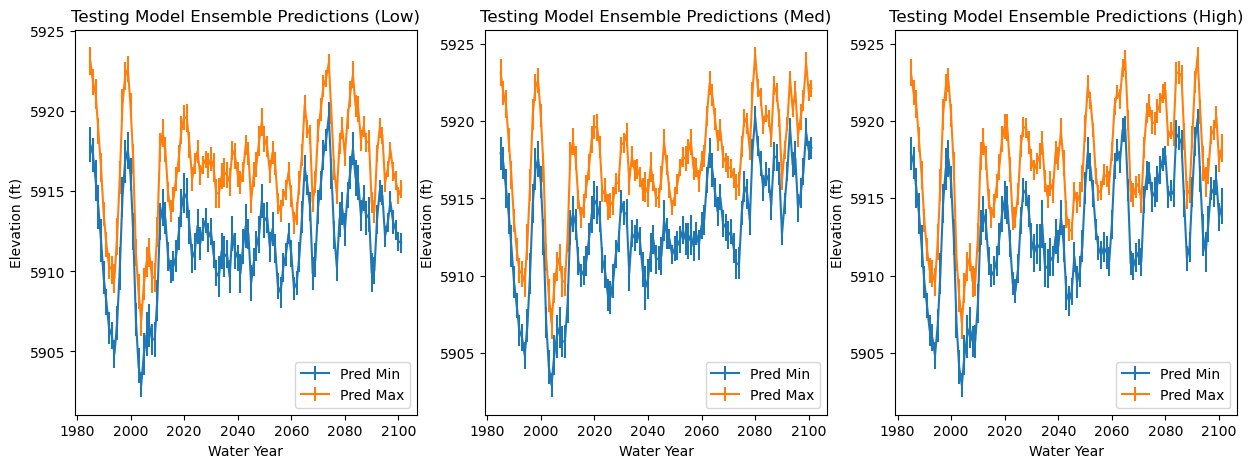

In [5]:
daily = pd.read_csv("data/other/Daily_ssp245_conv.csv", parse_dates=['date'])
daily_train = pd.read_csv("data/other/Daily.csv", parse_dates=['date']).iloc[:, 0:82-20]
# Keep the real first few year of data, then go into LOCA data
combined_daily = pd.concat([daily_train.iloc[0:, :].reset_index(drop=True), 
                            daily[daily['date'] >= datetime(2021, 10, 1)].reset_index(drop=True)], 
                            ignore_index=True)
combined_daily.drop(columns='Elevation', inplace=True)
# Get scaler from training data
scaler = BearLakeDataset(daily_train, 3*365, use_wateryear=False).scaler
dataset_test = BearLakeWaterYearLOCA(combined_daily, 3, scaler)
dataloader_test = DataLoader(dataset_test, batch_size=1024, shuffle=False)


model = GRU_MME()
model.load_state_dict(torch.load("data/other/finalModels/sub/sub_pt2_gru_model_final.pth"))
# device = 'cuda:3'
device = 'cpu'
model.to(device)

predictions = []
torch.manual_seed(789)
model.eval()
with torch.no_grad():
    for batch_X in dataloader_test:
        batch_X = batch_X.to(device)
        means, stds = model(batch_X)
means = means.detach().cpu().numpy()
stds = 3*stds.detach().cpu().numpy()


fig, axs = plt.subplots(1, 3)
fig.set_size_inches(15, 5)

axs[0].errorbar(x=dataset_test.wyear_elevations.year.dt.year.values, y=means[:, 0], yerr=stds[:, 0], label='Pred Min')
axs[0].errorbar(x=dataset_test.wyear_elevations.year.dt.year.values, y=means[:, 1], yerr=stds[:, 1], label='Pred Max')
axs[0].legend()
axs[0].set_title(f"Testing Model Ensemble Predictions (Low)")
axs[0].set_xlabel("Water Year")
axs[0].set_ylabel("Elevation (ft)")








daily = pd.read_csv("data/other/Daily_ssp370_conv.csv", parse_dates=['date'])
daily_train = pd.read_csv("data/other/Daily.csv", parse_dates=['date']).iloc[:, 0:82-20]
# Keep the real first few year of data, then go into LOCA data
combined_daily = pd.concat([daily_train.iloc[0:, :].reset_index(drop=True), 
                            daily[daily['date'] >= datetime(2021, 10, 1)].reset_index(drop=True)], 
                            ignore_index=True)
combined_daily.drop(columns='Elevation', inplace=True)
# Get scaler from training data
scaler = BearLakeDataset(daily_train, 3*365, use_wateryear=False).scaler
dataset_test = BearLakeWaterYearLOCA(combined_daily, 3, scaler)
dataloader_test = DataLoader(dataset_test, batch_size=1024, shuffle=False)


predictions = []
torch.manual_seed(789)
model.eval()
with torch.no_grad():
    for batch_X in dataloader_test:
        batch_X = batch_X.to(device)
        means, stds = model(batch_X)
means = means.detach().cpu().numpy()
stds = 3*stds.detach().cpu().numpy()

axs[1].errorbar(x=dataset_test.wyear_elevations.year.dt.year.values, y=means[:, 0], yerr=stds[:, 0], label='Pred Min')
axs[1].errorbar(x=dataset_test.wyear_elevations.year.dt.year.values, y=means[:, 1], yerr=stds[:, 1], label='Pred Max')
axs[1].legend()
axs[1].set_title(f"Testing Model Ensemble Predictions (Med)")
axs[1].set_xlabel("Water Year")
axs[1].set_ylabel("Elevation (ft)")



daily = pd.read_csv("data/other/Daily_ssp585_conv.csv", parse_dates=['date'])
daily_train = pd.read_csv("data/other/Daily.csv", parse_dates=['date']).iloc[:, 0:82-20]
# Keep the real first few year of data, then go into LOCA data
combined_daily = pd.concat([daily_train.iloc[0:, :].reset_index(drop=True), 
                            daily[daily['date'] >= datetime(2021, 10, 1)].reset_index(drop=True)], 
                            ignore_index=True)
combined_daily.drop(columns='Elevation', inplace=True)
# Get scaler from training data
scaler = BearLakeDataset(daily_train, 3*365, use_wateryear=False).scaler
dataset_test = BearLakeWaterYearLOCA(combined_daily, 3, scaler)
dataloader_test = DataLoader(dataset_test, batch_size=1024, shuffle=False)


predictions = []
torch.manual_seed(789)
model.eval()
with torch.no_grad():
    for batch_X in dataloader_test:
        batch_X = batch_X.to(device)
        means, stds = model(batch_X)
means = means.detach().cpu().numpy()
stds = 3*stds.detach().cpu().numpy()

axs[2].errorbar(x=dataset_test.wyear_elevations.year.dt.year.values, y=means[:, 0], yerr=stds[:, 0], label='Pred Min')
axs[2].errorbar(x=dataset_test.wyear_elevations.year.dt.year.values, y=means[:, 1], yerr=stds[:, 1], label='Pred Max')
axs[2].legend()
axs[2].set_title(f"Testing Model Ensemble Predictions (High)")
axs[2].set_xlabel("Water Year")
axs[2].set_ylabel("Elevation (ft)")

In [7]:
def generate_predictions(data_file, save_name=None, model_file="data/other/finalModels/sub/sub_pt2_gru_model_final.pth", use_swe=False,
                         gpu_id=2, plot=True, ax=None):
    daily = pd.read_csv(data_file, parse_dates=['date'])
    daily_train = pd.read_csv("data/other/Daily.csv", parse_dates=['date'])
    if not use_swe:
        daily_train = daily_train.iloc[:, 0:82-20]
    # Keep the real first few year of data, then go into LOCA data
    combined_daily = pd.concat([daily_train.iloc[0:, :].reset_index(drop=True), 
                                daily[daily['date'] >= datetime(2021, 10, 1)].reset_index(drop=True)], 
                                ignore_index=True)
    combined_daily.drop(columns='Elevation', inplace=True)
    # Get scaler from training data
    scaler = BearLakeDataset(daily_train, 3*365, use_wateryear=False).scaler
    dataset_test = BearLakeWaterYearLOCA(combined_daily, 3, scaler)
    dataloader_test = DataLoader(dataset_test, batch_size=1024, shuffle=False)

    model = GRU_MME()
    model.load_state_dict(torch.load(model_file))
    device = f'cuda:{gpu_id}'
    # device = 'cpu'
    model.to(device)

    torch.manual_seed(789)
    model.eval()
    with torch.no_grad():
        for batch_X in dataloader_test:
            batch_X = batch_X.to(device)
            means, stds = model(batch_X)
    means = means.detach().cpu().numpy()
    stds = 3*stds.detach().cpu().numpy()

    if plot:
        if ax is None:
            fig, ax = plt.subplots(1)
            fig.set_size_inches(5, 5)

        ax.errorbar(x=dataset_test.wyear_elevations.year.dt.year.values, y=means[:, 0], yerr=stds[:, 0], label='Pred Min')
        ax.errorbar(x=dataset_test.wyear_elevations.year.dt.year.values, y=means[:, 1], yerr=stds[:, 1], label='Pred Max')
        ax.legend()
        ax.set_title(f"{data_file}")
        ax.set_xlabel("Water Year")
        ax.set_ylabel("Elevation (ft)")
    if not save_name is None:
        print(f"Saving data at {save_name}")
        res = {
            'wateryear': dataset_test.wyear_elevations.year.dt.year.values,
            'min_elev': means[:, 0],
            'max_elev': means[:, 1],
            'min_uq': stds[:, 0],
            'max_uq': stds[:, 1]
        }
        df = pd.DataFrame(res)
        df.to_csv(save_name, index=False)

    return means, stds

Plot predictions

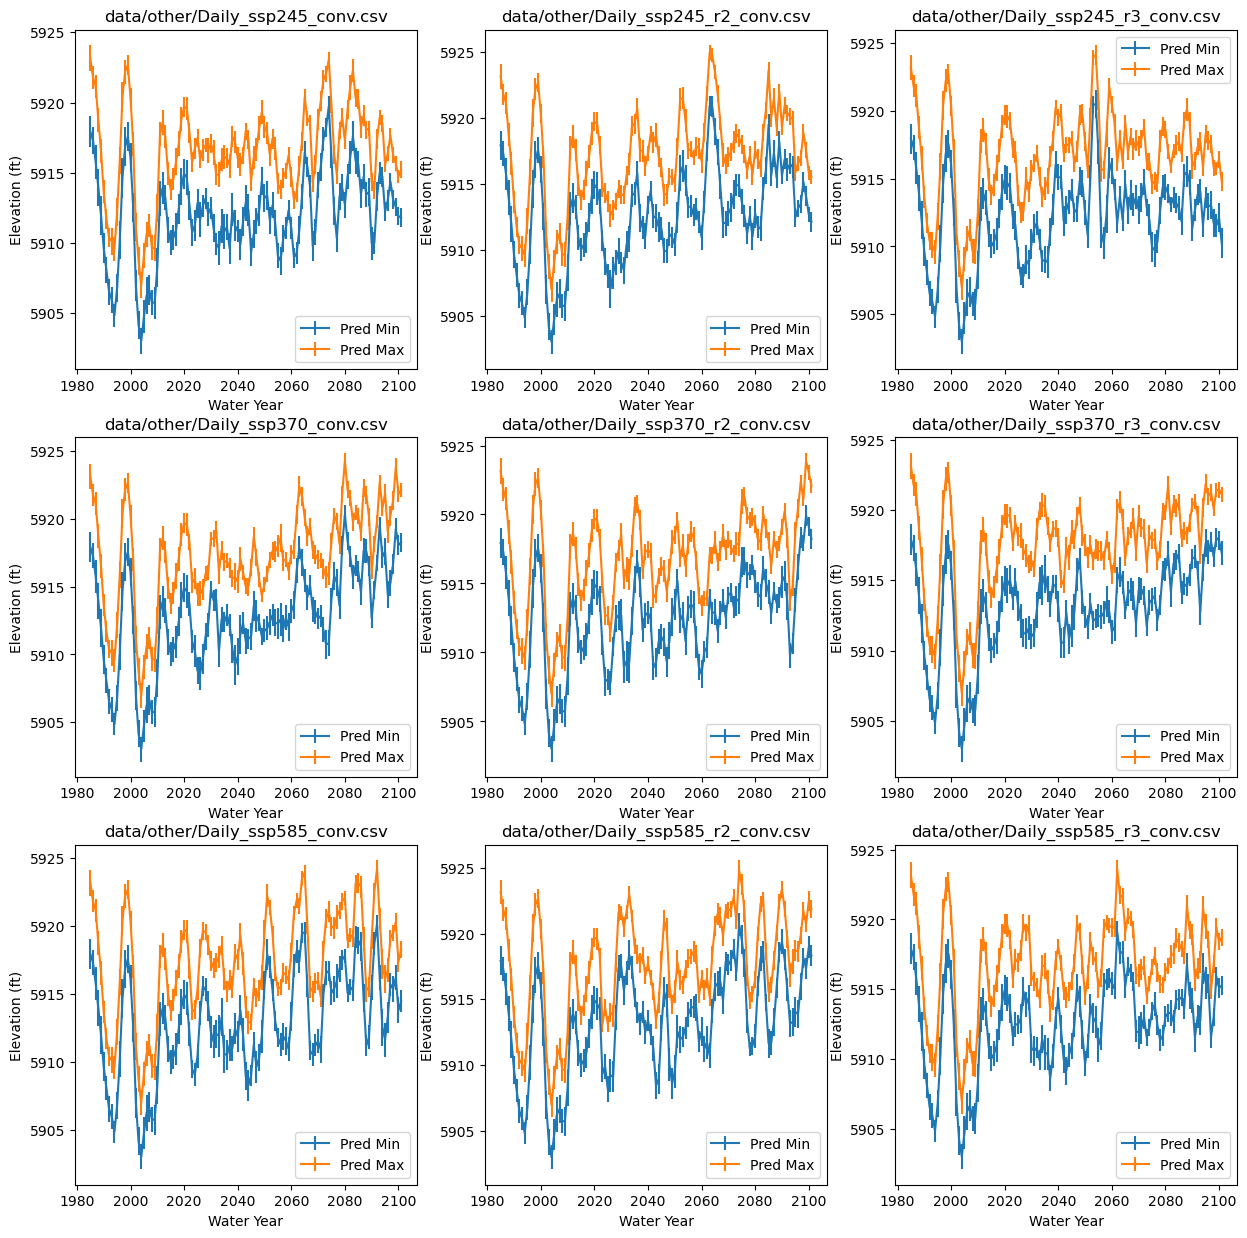

In [17]:
fig, axs = plt.subplots(3, 3)
fig.set_size_inches(15, 15)

for i, ds in enumerate(["ssp245", "ssp370", "ssp585"]):
    m, s = generate_predictions(f"data/other/Daily_{ds}_conv.csv", ax=axs[i, 0])

for i, ds in enumerate(["ssp245_r2", "ssp370_r2", "ssp585_r2"]):
    m, s = generate_predictions(f"data/other/Daily_{ds}_conv.csv", ax=axs[i, 1])

for i, ds in enumerate(["ssp245_r3", "ssp370_r3", "ssp585_r3"]):
    m, s = generate_predictions(f"data/other/Daily_{ds}_conv.csv", ax=axs[i, 2])

Save predicitons

In [15]:
for i, ds in enumerate(["ssp245", "ssp370", "ssp585"]):
    m, s = generate_predictions(f"data/other/Daily_{ds}_conv.csv", f"data/other/GRU_{ds}r1.csv", plot=False)

for i, ds in enumerate(["ssp245_r2", "ssp370_r2", "ssp585_r2"]):
    m, s = generate_predictions(f"data/other/Daily_{ds}_conv.csv", f"data/other/GRU_{ds.split('_')[0]}r2.csv", plot=False)

for i, ds in enumerate(["ssp245_r3", "ssp370_r3", "ssp585_r3"]):
    m, s = generate_predictions(f"data/other/Daily_{ds}_conv.csv", f"data/other/GRU_{ds.split('_')[0]}r3.csv", plot=False)

Saving data at data/other/GRU_ssp245r1.csv
Saving data at data/other/GRU_ssp370r1.csv
Saving data at data/other/GRU_ssp585r1.csv
Saving data at data/other/GRU_ssp245r2.csv
Saving data at data/other/GRU_ssp370r2.csv
Saving data at data/other/GRU_ssp585r2.csv
Saving data at data/other/GRU_ssp245r3.csv
Saving data at data/other/GRU_ssp370r3.csv
Saving data at data/other/GRU_ssp585r3.csv
